In [2]:
# required to pip install xgboost

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from numpy import array  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os 
import math
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


In [4]:
SEED = 123
def seed_everything(seed=SEED):
    """
    Set the random seed for Python, NumPy, and random module.

    Parameters:
    - seed (int): The seed value to set for randomness. Defaults to 42.

    Returns:
    - None
    """
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

In [5]:
#GLOBAL VARIABLES
#define percentage of test_split
test_size = 0.2
# Define the programmer whose path you want to use
programmer = 'esther'

#variables for paths names
file_paths_names = {
    'patricia': r"..\original_data",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data"
}

files_outcome_path_names = {
    'patricia': r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION\original_data\outcomes",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data\outcomes"
}

#TODO: patricia to add his path properly
files_path_to_save_files = {
    'patricia': r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\clean_data"
}

# Choose the file path based on the programmer variable
file_path_to_save = files_path_to_save_files[programmer]
file_path_to_open = file_path_to_save

#name of files to test with the model
filename_no_nan_imputed = 'clean_dataframe_with_NaN.csv'
filename_KNN_nan_imputed = 'clean_dataframe_NaN_KNN_imputed.csv'
filename_PCA_nan_imputed = 'clean_dataframe_NaN_PCA_imputed.csv'




In [6]:
def prepare_data_for_xgboost(filename, file_path):
    # Read the CSV file
    final_dataframe = pd.read_csv(os.path.join(file_path, filename))
    
    # Generate BMI
    final_dataframe['BMI'] = final_dataframe['Weight_median'] / ((final_dataframe['Height'] / 100) ** 2)
    
    # Drop unnecessary columns
    final_dataframe.drop(columns=['Height', 'Weight_median'], inplace=True)
    
    return final_dataframe

### 1. Using KNN inputed NAN file

#### 1-Load data

In [7]:
filename = 'clean_dataframe_NaN_KNN_imputed.csv'
final_dataframe = prepare_data_for_xgboost(filename, file_path_to_open)

In [8]:
pd.options.display.max_columns = None
final_dataframe.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,MechVent_start,Albumin_median,Albumin_mad,ALP_median,ALP_mad,ALT_mad,AST_median,AST_mad,Bilirubin_median,Bilirubin_mad,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,Creatinine_slope,DiasABP_median,DiasABP_max,DiasABP_mad,DiasABP_last,FiO2_median,FiO2_max,FiO2_mad,FiO2_last,FiO2_slope,GCS_median,GCS_mad,GCS_slope,Glucose_median,Glucose_max,Glucose_mad,Glucose_last,Glucose_slope,HCO3_median,HCO3_mad,HCO3_slope,HCT_median,HCT_mad,HCT_slope,HR_median,HR_max,HR_mad,HR_last,HR_slope,K_48median,K_median,K_max,K_mad,K_slope,Lactate_median,Lactate_mad,Lactate_slope,Mg_median,Mg_max,Mg_mad,Mg_last,Mg_slope,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIDiasABP_median,NIDiasABP_max,NIDiasABP_mad,NIDiasABP_last,NIDiasABP_slope,NIMAP_mad,NISysABP_median,NISysABP_mad,NISysABP_last,NISysABP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaO2_median,PaO2_max,PaO2_mad,PaO2_last,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,SaO2_median,SaO2_mad,SaO2_slope,SysABP_median,SysABP_mad,SysABP_last,SysABP_slope,Temp_48median,Temp_median,Temp_max,Temp_mad,Temp_last,Temp_slope,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
932,134886.0,77.0,0.0,4.0,22.125688,1.0,1.0,2.983,1.548427,94.63,3.285807,7.389269,209.795,10.921955,2.4975,6.518135,23.5,27.659574,-0.541667,1.0,10.0,-0.008333,57.13875,75.6675,7.678209,58.5775,0.5,0.6,0.0,0.5,-0.00611,13.0,3.846154,0.150125,114.5,131.0,14.41048,98.0,-1.375,24.5,2.040816,-0.041667,27.85,0.179533,-0.004167,74.0,92.0,11.486486,87.0,0.420373,3.6,3.8,4.0,5.263158,-0.016667,2.368625,13.264123,-0.042116,2.15,2.2,2.325581,2.1,-0.004167,78.7075,104.28,7.336412,81.565,0.149764,143.5,1.045296,0.125,51.0,76.0,6.862745,60.0,0.016481,4.142012,150.5,5.647841,164.0,0.139044,39.31875,45.0225,6.051491,136.7225,226.7925,16.56165,115.175,-3.650097,7.375762,0.309493,183.0,3.278689,-0.5,97.0425,0.461719,0.019065,116.675,7.746898,120.49,0.135705,37.2,37.1,38.3,1.212938,36.7,0.01393,60.0,140.0,29.166667,60.0,-0.214587,9.6,20.833333,0.166667,0.0,-0.001005,14,0


In [9]:
categorical_features = ['Gender', 'ICUType', 'MechVent']       

#### 2-Look at the distribution target("type") variable

In [10]:
final_dataframe['In-hospital_death'].value_counts()
num_pos_samples = final_dataframe['In-hospital_death'].value_counts()[1]
num_neg_samples  = final_dataframe['In-hospital_death'].value_counts()[0]

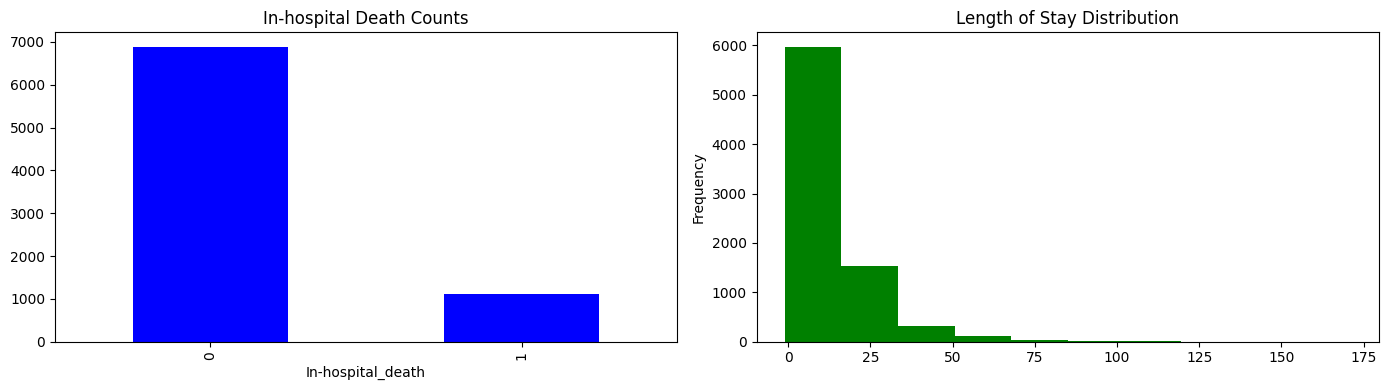

In [11]:
# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
final_dataframe['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
final_dataframe['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()

#### 3-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create two variables**

X = training data with all features except target variable

y = target variable "In-hospital_death"

Drop "Length_of_stay" and use "RecordID"  as index

In [12]:
# Extract features and target variable
X = final_dataframe.drop(columns=['In-hospital_death', 'Length_of_stay'])  # Drop the target variable and 'Length_of_stay' column
y = final_dataframe['In-hospital_death']

# Set 'RecordID' as the index
X.set_index('RecordID', inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size= test_size,
        random_state = SEED
    )

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6400, 116)
X_test shape: (1600, 116)
y_train shape: (6400,)
y_test shape: (1600,)


To train an XGBoost model on these data, you need to convert them into a format that XGBoost can interpret: the xgb.DMatrix format. </br>
To do this, simply use the DMatrix() function

In [13]:
# Convert training and testing data to DMatrix format
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [14]:
dataframe_dmatrix = xgb.DMatrix(data=X, label=y)

##### 3-2 Define the tuning parameters for the model

Using XGBClassifier() in combination with RandomizedSearchCV or GridSearchCV is a common approach for hyperparameter tuning and model selection. RandomizedSearchCV, samples from a distribution of parameters, and GridSearchCV evaluates all possible combinations of hyperparameters provided in a grid.

When tuning XGBoost models for classification tasks, there are several important parameters to consider. Here are some of the most crucial ones:

- Learning Rate (eta): The learning rate controls the step size during the gradient descent optimization process. Lower values typically result in slower learning but can lead to better generalization.

- Maximum Depth (max_depth): How deeply a tree is allowed to grow during each boosting round.  Deeper trees can capture more complex patterns in the data but are more prone to overfitting.

- Minimum Child Weight (min_child_weight): This parameter specifies the minimum sum of instance weight needed in a child node. It helps to control overfitting by constraining the partitioning of leaf nodes.

- Subsample:Subsample controls the fraction of training data to be used for each boosting round. If the value is low we can run into underfitting, if the value is very high we may run into overfitting.
  
- Column Subsampling (colsample_bytree or colsample_bylevel): These parameters control the fraction of features (columns) to be used for each tree or each level of trees, respectively during any boosting round. a large value means that almost all features can be used to build a tree during every boosting round. In general a small value can be thought as providing additional regularization to the model, using all columns may overfit a training model. They help introduce diversity into the ensemble and reduce overfitting. As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.

- Regularization Parameters (lambda, alpha):
Lambda (L2 regularization) and alpha (L1 regularization) control the amount of regularization applied to the weights of the trees. They help prevent overfitting by penalizing large parameter values.

- Number of Trees (num_boost_round):
This parameter specifies the maximum number of boosting rounds (trees) to be trained. Increasing the number of trees can improve performance, but it's essential to monitor for overfitting.

Early Stopping (early_stopping_rounds): Early stopping allows training to stop if the performance on a validation dataset does not improve for a specified number of rounds. It helps prevent overfitting and reduces training time.

Objective Function: The choice of objective function depends on the specific classification problem (e.g., binary classification, multiclass classification). Common options include binary logistic regression (binary classification) and softmax (multiclass classification).

Scale Pos Weight: This parameter is used to balance the positive and negative weights in binary classification tasks with imbalanced class distributions.

A thought on metrics
To evaluate the model I think the best is to us PR AUC (precision-recall curve):

PR-AUC (Precision-Recall Area Under the Curve) is an ML metric used to evaluate the performance of binary classification models, mainly when the classes are imbalanced. Unlike the ROC curve and AUC, which plot the TPR against the FPR, the PR curve plots the precision against the recall at different threshold settings

In [15]:
# Define a custom scorer based Area Under the Precision-Recall Curve (AUC-PR), which specifically evaluates the trade-off between precision and recall. 
def auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Create a scorer using the AUC-PR function
pr_scorer = make_scorer(auc_pr, greater_is_better=True)

In [24]:
#xgb – this is the direct xgboost library. I will use a specific function, “cv” from this library
#XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM.

#define parameter grid
gbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 7, 9],
    #'min_child_weight': [1, 5, 10], NEED HELP ON HOW TOSET UP THIS
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'scale_pos_weight': [np.sqrt(num_neg_samples / num_pos_samples)] #scale_pos_weight is the ratio of number of negative class to the positive class.
}

# Create XGBClassifier instance
xgb_regressor = xgb.XGBClassifier()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator = xgb_regressor,
                           param_grid = gbm_param_grid,
                           scoring= pr_scorer,  # Use custom auc_pr
                           cv = 3)  # 4-fold cross-validation

# Fit the grid search to the data
#grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Convert cv_results_ to a DataFrame


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'